In [1]:
import os
import torch
from torch import nn, optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report, accuracy_score
from PIL import Image

In [2]:
class_names = ['Fake', 'Real']
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
BATCH_SIZE = 64
EPOCHS = 10
LEARNING_RATE = 0.001

In [3]:
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# For test, keep only resizing and normalization
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


In [4]:
def get_loader(path, shuffle=True, transform=None):
    dataset = datasets.ImageFolder(path, transform=transform)
    return DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=shuffle)

train_loader = get_loader('dataset/train', shuffle=True, transform=train_transform)
test_loader = get_loader('dataset/test', shuffle=False, transform=test_transform)

In [5]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),  # [B, 3, 224, 224] -> [B, 16, 224, 224]
            nn.ReLU(),
            nn.MaxPool2d(2),                             # [B, 16, 112, 112]

            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),                             # [B, 32, 56, 56]

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)                              # [B, 64, 28, 28]
        )

        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 28 * 28, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.conv(x)
        x = self.fc(x)
        return x


In [6]:
def train_model(model, loader):
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-3)


    model.train()
    for epoch in range(EPOCHS):
        total_loss = 0
        for images, labels in loader:
            images = images.to(DEVICE)
            labels = labels.float().unsqueeze(1).to(DEVICE)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
        print(f"Epoch {epoch+1}/{EPOCHS}, Loss: {total_loss / len(loader):.4f}")

In [7]:
def test_model(model, loader):
    model.eval()
    y_true, y_pred = [], []

    with torch.no_grad():
        for images, labels in loader:
            images = images.to(DEVICE)
            labels = labels.to(DEVICE)
            outputs = model(images)
            preds = (outputs > 0.5).int()
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    print("\nTest Accuracy:", accuracy_score(y_true, y_pred))
    print(classification_report(y_true, y_pred, target_names=class_names))


In [8]:
model = SimpleCNN().to(DEVICE)

In [9]:
print("Training custom CNN model...")
train_model(model, train_loader)

Training custom CNN model...
Epoch 1/10, Loss: 0.3483
Epoch 2/10, Loss: 0.2566
Epoch 3/10, Loss: 0.2316
Epoch 4/10, Loss: 0.2223
Epoch 5/10, Loss: 0.2218
Epoch 6/10, Loss: 0.2082
Epoch 7/10, Loss: 0.1969
Epoch 8/10, Loss: 0.1949
Epoch 9/10, Loss: 0.1914
Epoch 10/10, Loss: 0.1824


In [10]:
print("\nEvaluating on test set...")
test_model(model, test_loader)


Evaluating on test set...

Test Accuracy: 0.663
              precision    recall  f1-score   support

        Fake       0.94      0.35      0.51       500
        Real       0.60      0.98      0.74       500

    accuracy                           0.66      1000
   macro avg       0.77      0.66      0.63      1000
weighted avg       0.77      0.66      0.63      1000



In [12]:
torch.save(model.state_dict(), "deepfake_cnn_model.pkl")

In [15]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

def test_model(model, loader):
    model.eval()
    y_true = []
    y_pred = []

    with torch.no_grad():
        for images, labels in loader:
            images = images.to(DEVICE)
            labels = labels.to(DEVICE)

            outputs = model(images)
            preds = (outputs > 0.5).int()

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    # Metrics
    acc = accuracy_score(y_true, y_pred)
    print("\nTest Accuracy:", acc)
    print(classification_report(y_true, y_pred, target_names=class_names))

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()



Test Accuracy: 0.663
              precision    recall  f1-score   support

        Fake       0.94      0.35      0.51       500
        Real       0.60      0.98      0.74       500

    accuracy                           0.66      1000
   macro avg       0.77      0.66      0.63      1000
weighted avg       0.77      0.66      0.63      1000



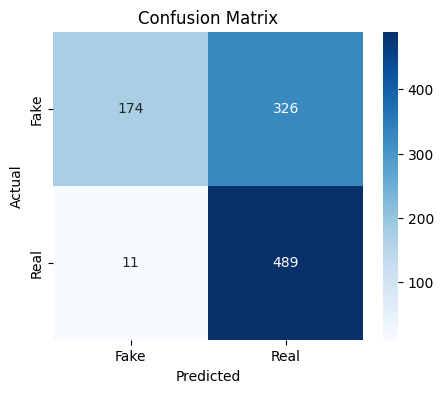

In [16]:
test_model(model, test_loader)

In [22]:
from PIL import Image
import torch

def predict_probability(image_path, model, transform):
    image = Image.open(image_path).convert('RGB')
    image = transform(image).unsqueeze(0).to(DEVICE)  # [1, 3, 224, 224]

    model.eval()
    with torch.no_grad():
        output = model(image)
        probability = output.item()

    return 1-probability  # Float between 0 and 1


In [33]:
image_path="img6.jpg"
rob = predict_probability(image_path, model, test_transform)

In [34]:
rob

0.05147188901901245